In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


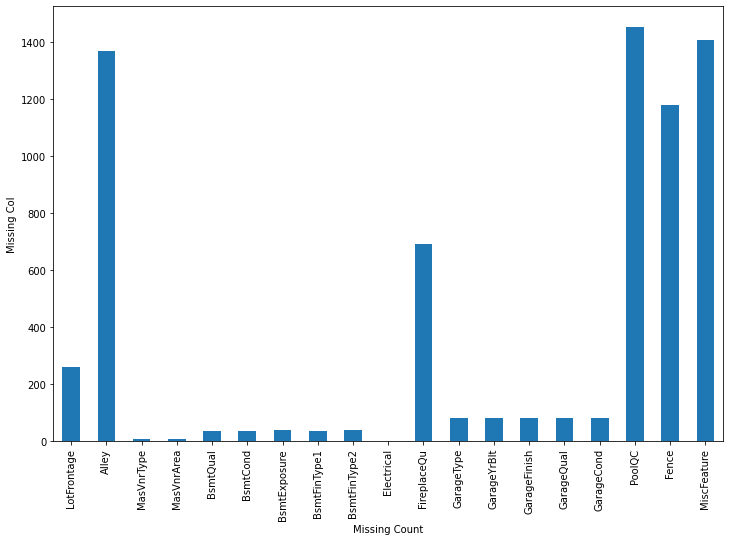

In [6]:
def plot_missing(df): 
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.plot.bar(figsize=(12,8))
    plt.ylabel ('Missing Col')
    plt.xlabel ('Missing Count')
    
plot_missing(train)

<AxesSubplot:xlabel='LotFrontage', ylabel='Density'>

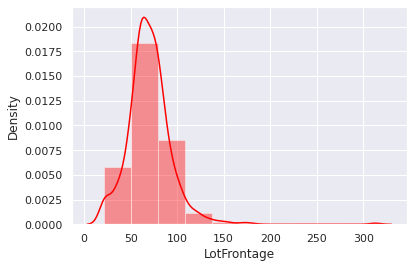

In [7]:
sns.set()
sns.distplot(train["LotFrontage"], kde=True, color='red', bins=10)

In [8]:
train['LotFrontage'].mean(),train['LotFrontage'].median()

(70.04995836802665, 69.0)

In [9]:
def fill_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    for column in list(missing.index):
        if df[column].dtype == 'object':
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        elif df[column].dtype == 'int64' or 'float64' or 'int16' or 'float16':
            df[column].fillna(df[column].median(), inplace=True)
fill_missing_values(train)
train.isnull().sum().max()

0

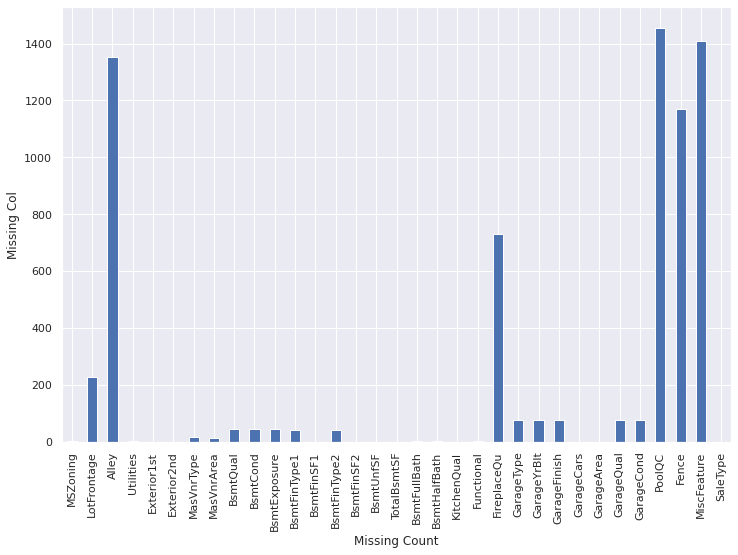

In [10]:
plot_missing(test)

In [11]:
fill_missing_values(test)
test.isnull().sum().max()

0

In [12]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [13]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [14]:
def Encode_Obj(df):
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    temp_cols = []
    for col in object_cols:
        temp_cols.append(df.columns.get_loc(col))
    le = LabelEncoder()
    for i in temp_cols:
        df.iloc[:,i] = le.fit_transform(df.iloc[:,i])

In [15]:
Encode_Obj(train)
Encode_Obj(test)

In [16]:
X = train.drop('SalePrice', axis = 1)
y = np.ravel(np.array(train[['SalePrice']]))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
RandomForest = RandomForestRegressor(n_estimators=15)
kf = KFold(n_splits = 5)
y_pred = cross_val_score(RandomForest, X, y, cv=kf, n_jobs=-1)
y_pred.mean()

0.8528825743134469

In [19]:
RandomForest.fit(X, y)

RandomForestRegressor(n_estimators=15)

In [20]:
Predict = RandomForest.predict(test)

In [21]:
submission = pd.DataFrame({'Id':test.Id , 'SalePrice': Predict})
submission.to_csv('submission.csv',index = False)